In [1]:
import math
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Polygon, Circle
from pandas import Series

In [2]:
def calculate_area(row: Series) -> float:
    earth_radius_km: float = 6371.0
    delta_longitude: float = np.radians(row['Eastern'] - row['Western'])
    southern_latitude: float = np.radians(row['Southern'])
    northern_latitude: float = np.radians(row['Northern'])
    area: float = (earth_radius_km ** 2) * delta_longitude * (np.sin(northern_latitude) - np.sin(southern_latitude))
    return area


def calculate_center_coordinates(row: pd.Series) -> Tuple[float, float]:
    """Calculate the center latitude and longitude for a given box.

    Args:
        row (pd.Series): A Pandas Series representing a row of the DataFrame with ('southern', 'northern', 'western', 'eastern') coordinates.

    Returns:
        Tuple[float, float]: A tuple containing the center latitude and longitude.
    """
    center_latitude = 0.5 * (math.sin(row['Southern'] * math.pi / 180) + math.sin(row['Northern'] * math.pi / 180))
    center_longitude = 0.5 * (row['Western'] + row['Eastern'])
    center_latitude = math.asin(center_latitude) * 180 / math.pi
    return center_latitude, center_longitude


def generate_80_cell_grid() -> pd.DataFrame:
    """Generate an 80-cell grid DataFrame with columns for southern, northern, western, eastern,
    center_latitude, and center_longitude coordinates.

    Returns:
        pd.DataFrame: The generated DataFrame.
    """
    grid_data = []
    
    # Number of horizontal boxes in each band
    # (proportional to the thickness of each band)
    band_boxes = [4, 8, 12, 16]
    
    # Sines of latitudes
    band_altitude = [1, 0.9, 0.7, 0.4, 0]

    # Generate the 40 cells in the northern hemisphere
    for band in range(len(band_boxes)):
        n = band_boxes[band]
        for i in range(n):
            lats = 180 / math.pi * math.asin(band_altitude[band + 1])
            latn = 180 / math.pi * math.asin(band_altitude[band])
            lonw = -180 + 360 * float(i) / n
            lone = -180 + 360 * float(i + 1) / n
            box = (lats, latn, lonw, lone)
            grid_data.append(box)

    # Generate the 40 cells in the southern hemisphere by reversing the northern hemisphere cells
    for box in grid_data[::-1]:
        grid_data.append((-box[1], -box[0], box[2], box[3]))

    # Create a DataFrame from the grid data
    df = pd.DataFrame(grid_data, columns=['Southern', 'Northern', 'Western', 'Eastern'])

    # Calculate center coordinates for each box and add them as new columns
    center_coords = df.apply(calculate_center_coordinates, axis=1)
    df[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=df.index)

    return df


def plot_grid_80(grid_80):

    # Create a Matplotlib figure and axis with Robinson projection
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    # Add a map background
    ax.stock_img()

    # Iterate over the rows of the grid_80 dataframe to create polygons
    for index, row in grid_80.iterrows():
        southern, northern, western, eastern = row['Southern'], row['Northern'], row['Western'], row['Eastern']

        # Create a Polygon for the grid cell
        polygon = Polygon([(western, southern), (western, northern), (eastern, northern), (eastern, southern)],
                          closed=True, edgecolor='blue', facecolor='none', transform=ccrs.PlateCarree())

        # Add the Polygon to the plot
        ax.add_patch(polygon)

    # Pick a cell center point
    idx = 30
    selected_lat = grid_80.iloc[idx]['Center_Latitude']
    selected_lon = grid_80.iloc[idx]['Center_Longitude']

    # Calculate latitude and longitude offsets for a 1200km radius
    radius_km = 1200.0
    lat_offset = radius_km / 111.32
    lon_offset = radius_km / (111.32 * math.cos(math.radians(selected_lat)))

    # Create a circle centered at the selected point
    circle = Circle((selected_lon, selected_lat), radius=lat_offset, edgecolor='yellow', facecolor='none',
                    linewidth=3.0, transform=ccrs.PlateCarree())

    # Add the circle to the plot
    ax.add_patch(circle)

    # Plot scatter points
    lons = grid_80['Center_Longitude']
    lats = grid_80['Center_Latitude']
    ax.scatter(lons, lats, color='red', s=50, transform=ccrs.PlateCarree())

    # Customize the plot
    ax.set_title('Scatter Plot with Grid Outline and 1200km Radius Circle')

    # Display the plot
    plt.show()
    
    
def interpolate(x: float, y: float, p: float) -> float:
    return y * p + (1 - p) * x


def generate_8000_cell_grid(grid_80):

    # Initialize an empty list to store subboxes
    subbox_list = []

    for index, row in grid_80.iterrows():
        alts = math.sin(row['Southern'] * math.pi / 180)
        altn = math.sin(row['Northern'] * math.pi / 180)

        for y in range(10):
            s = 180 * math.asin(interpolate(alts, altn, y * 0.1)) / math.pi
            n = 180 * math.asin(interpolate(alts, altn, (y + 1) * 0.1)) / math.pi
            for x in range(10):
                w = interpolate(row['Western'], row['Eastern'], x * 0.1)
                e = interpolate(row['Western'], row['Eastern'], (x + 1) * 0.1)

                # Create a DataFrame for the subbox
                subbox_df = pd.DataFrame({'Southern': [s], 'Northern': [n], 'Western': [w], 'Eastern': [e]})

                # Append the subbox DataFrame to the list
                subbox_list.append(subbox_df)

    # Concatenate all subboxes into a single DataFrame
    grid_8000 = pd.concat(subbox_list, ignore_index=True)

    # Calculate center coordinates for each box and add them as new columns
    center_coords = grid_8000.apply(calculate_center_coordinates, axis=1)
    grid_8000[['Center_Latitude', 'Center_Longitude']] = pd.DataFrame(center_coords.tolist(), index=grid_8000.index)

    # Calculate area of all 8000 cells
    grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)

    # Print the resulting DataFrame
    return grid_8000


def plot_grid_8000(grid_8000):
    
    # Create a Matplotlib figure and axis with Robinson projection
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.Robinson())

    # Add a map background
    ax.stock_img()

    # Pick a cell center point
    idx = 3000
    selected_lat = grid_8000.iloc[idx]['Center_Latitude']
    selected_lon = grid_8000.iloc[idx]['Center_Longitude']

    # Calculate latitude and longitude offsets for a 1200km radius
    radius_km = 1200.0
    lat_offset = radius_km / 111.32
    lon_offset = radius_km / (111.32 * math.cos(math.radians(selected_lat)))

    # Create a circle centered at the selected point
    circle = Circle((selected_lon, selected_lat), radius=lat_offset, edgecolor='black', facecolor='none',
                    linewidth=5.0, transform=ccrs.PlateCarree())

    # Add the circle to the plot
    ax.add_patch(circle)

    # Plot scatter points
    lats = grid_8000['Center_Latitude']
    lons = grid_8000['Center_Longitude']
    ax.scatter(lons, lats, color='red', s=1, transform=ccrs.PlateCarree())

    # Customize the plot
    ax.set_title('Scatter Plot with 8000 Cell Grid and 1200km Radius Circle')

    # Display the plot
    plt.show()

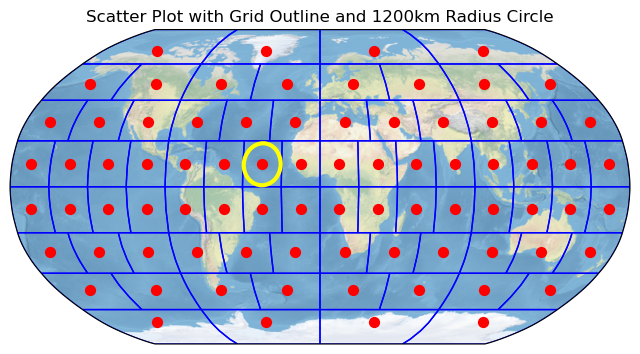

In [5]:
grid_80 = generate_80_cell_grid()
grid_80['Area'] = grid_80.apply(calculate_area, axis=1)
plot_grid_80(grid_80)

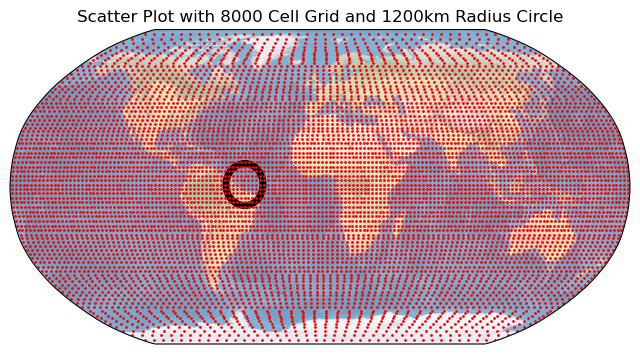

In [4]:
grid_8000 = generate_8000_cell_grid(grid_80)
grid_8000['Area'] = grid_8000.apply(calculate_area, axis=1)
plot_grid_8000(grid_8000)